## Helper Functions

In [187]:
def show_binary_image(image, title=None, size=(15,12)):
    '''Function to output binary thresholded image using matpltlib'''
    plt.figure(figsize=size)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    if title != None:
        plt.title(title)
    plt.show()
    
def show_image(image, title=None, size=(15,12), cmap = None, axis= False):
    '''Function to show a rgb image'''
    plt.figure(figsize=size)

    if cmap == 'hot':
        plt.imshow(image, cmap='hot')
    elif cmap == 'gray':
            plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    if axis == False:
        plt.axis('off')
    if title != None:
        plt.title(title)
    plt.show()
    

## Feature Extraction Class

In [1]:
import numpy as np
import cv2
from skimage.feature import hog



class FeatureExtraction(object):
    
    def __init__(self, img, colour_space= 'HSV', orient_bins = 10, pixels_per_cell = 8, cells_per_block =2):
        
        self.orientation = orient_bins
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        
        #Convert the image pixels into the desired colour space
        if colour_space != 'RGB':
            if colour_space == 'HSV':
                self.image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif colour_space == 'LUV':
                self.image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif colour_space == 'HLS':
                self.image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif colour_spsptace == 'YUV':
                self.image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif colour_space == 'YCrCb':
                self.image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: self.image = np.copy(img)
            
        #Get the dimensions of the image
        image_shape = self.image.shape
        self.height = image_shape[0]
        self.width = image_shape[1]
        self.depth = image_shape[2]
        
        #compute the hog features for the whole image over each channel
        self.hog_features = []
        for i in range(self.depth):
            
            hog_feat = hog(self.image[:,:,i], orientations = orient_bins, pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                          cells_per_block=(cells_per_block, cells_per_block), transform_sqrt=True, visualise=False,
                           feature_vector=False)
            self.hog_features.append(hog_feat)
            
        self.hog_features = np.asarray(self.hog_features)
        
    def colour_hist(self, img, nbins=32):  #bins_range=(0,256)
        #compute the histrogram of colour channels separatley
        channel0_hist = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))
        channel1_hist = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))
        channel2_hist = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))
        
        hist_features = np.concatenate((channel0_hist[0], channel1_hist[0], channel2_hist[0]))
        
        return hist_features
    
    def bin_spatial(self, img, size=(32,32)):
        colour1 = cv2.resize(img[:,:,0], size).ravel()
        colour2 = cv2.resize(img[:,:,1], size).ravel()
        colour3 = cv2.resize(img[:,:,2], size).ravel()
        return np.hstack((colour1, colour2, colour3))
    
    def hog(self, x, y, region_size):
        
        region = (region_size// self.pixels_per_cell) - 1
        
        location_x = x// self.pixels_per_cell
        location_y = y// self.pixels_per_cell
        
        #if (location_x + region) > self.hog_features.shape[2]:
        #    location_x = self.hog_features.shape[2] - region
            
        #if (location_y + region) > self.hog_features.shape[1]:
        #    location_y = self.hog_features.shape[1] - region
            
        return np.ravel(self.hog_features[:, location_y:location_y+region,  location_x:location_x+region, :, :, :])
            
            
        
    def get_features(self, x=0, y=0, region_size=64, spatial=True, colour_hist=True, hog_features=True):
        features = []       
        if spatial:
            spatial_features = self.bin_spatial(self.image[y:y+region_size, x:x+region_size, :])
            features.append(spatial_features)          
       
        if colour_hist:
            colour_hist_features = self.colour_hist(self.image[y:y+region_size, x:x+region_size, :])
            features.append(colour_hist_features)           
       
        if hog_features:
            hog_features = self.hog(x, y, region_size)
            features.append(hog_features)
            
        return np.concatenate(features)
            
        
            
        
        
            
       

## Read in data

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
%matplotlib inline

##Read in the training data and make them into matrices

cars = []
non_cars = []
car_paths = glob.glob('../Data/vehicles/*/*.png')
non_car_paths = glob.glob('../Data/non-vehicles/*/*.png')
for path in car_paths:
    cars.append(mpimg.imread(path))
for path in non_car_paths:
    non_cars.append(mpimg.imread(path))
    
cars = np.asarray(cars)
non_cars = np.asarray(non_cars)
    

## Extract Features

In [ ]:
car_features = []
non_car_features = []

for car in cars:
    car_features.append(FeatureExtraction(car).get_features())
for non_car in non_cars:
    non_car_features.append(FeatureExtraction(non_car).get_features())

car_features = np.asarray(car_features)
non_car_features = np.asarray(non_car_features)

In [ ]:
##Save the extracted features to disk (dataset too large to fit into laptop memory)
print(car_features.shape)
print(non_car_features.shape)

np.savez_compressed('../Data/Extracted_features', car_features = car_features, non_car_features = non_car_features)

## Create Training and  Test Data set

In [ ]:
##Load the extracted features from disk
loaded = np.load('../Data/Extracted_features.npz')
car_features = loaded['car_features']
non_car_features = loaded['non_car_features']

In [ ]:
# Combine and preprocess the training data set

from sklearn.preprocessing import StandardScaler
#note: train test split does both the shuffle and the split of the data
from sklearn.model_selection import train_test_split

X = np.vstack((car_features, non_car_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

rand_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

X_scaler = StandardScaler().fit(X_train)

#Normalise the datasets seperate to avoid any lookahead bias entering the data
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)



## Train Linear SVM

In [ ]:
from sklearn.svm import LinearSVC

svc = LinearSVC()
svc.fit(scaled_X_train, y_train)

print('Test Accuracy of SVM = ', svc.score(scaled_X_test, y_test))

### Save Model

In [ ]:
import pickle
#Save model to disk
filename= '../Models/linear_svm.sav'
pickle.dump(svc, open(filename, 'wb'))
#Save data normalisation routine
filename = '../Models/X_scaler.sav'
pickle.dump(X_scaler, open(filename, 'wb'))

### Load Model

In [3]:
import pickle

filename = '../Models/linear_svm.sav'
svc = pickle.load(open(filename, 'rb'))
#print('Test Accuracy of SVM = ', svc.score(scaled_X_test, y_test))

filename = '../Models/X_scaler.sav'
X_scaler = pickle.load(open(filename, 'rb'))

## VechicleDetection

In [198]:
from collections import deque

from skimage.transform import resize
from scipy.ndimage.measurements import label

pix_per_cell = 8
cells_per_block =2
orient = 10

class VehicleDectection(object):
    
    def __init__(self, normalisation, classifier, initalise_frame):
        
        self.X_scaler = normalisation
        self.classifier = classifier
        self.image_shape = initalise_frame.shape
        self.previous_detections = deque(maxlen=15)
        
    def detect_vehicles(self, image):
        
        scales = np.array([ 0.9, 2.0, 3.0, 0.75])
        ytop = np.array([450, 350, 400, 400])
        ybottom = np.array([550, 600, 600, 450])
        
        detected_windows = np.empty([0, 4], dtype=np.int64)
        
        for scale, y_top, y_bottom in zip(scales, ytop, ybottom):
            _, scaled_detections = self.search_windows_scale(image, scale, y_top, y_bottom, 64)
            
            detected_windows = np.append(detected_windows, scaled_detections, axis=0)
            
        img_det_win = self.draw_detections(image, detected_windows)
        
        
        ## Create the heatmap of the classfier detections
        heatmap_empty = np.zeros_like(image)[:,:,0]
        heatmap = self.add_heat(heatmap_empty, detected_windows)
        
        #Detect the number of cars in the heatmap
        labels = label(heatmap)
        print(labels[1], ' cars found')
        
        #Draw the bounding boxes onto the image
        final_image = self.draw_labeled_bboxes( image, labels)
        
        
        return detected_windows, img_det_win, heatmap, final_image
           
    def search_windows_scale(self, img, scale, y_start, y_stop, window_size):

            original_image = np.copy(img)

            detections = np.empty([0, 4], dtype=np.int)

            #Restrict the image the search area
            image = img[y_start:y_stop, :, :]
            image = image.astype(np.float32)/255

            imshape =  image.shape
            img_scaled = cv2.resize(image, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

            imshape_scaled = img_scaled.shape
            extraction = FeatureExtraction(img_scaled)

            # Define blocks and steps to transverse
            nxblocks = (imshape_scaled[1] // pix_per_cell) - cells_per_block + 1
            nyblocks = (imshape_scaled[0] // pix_per_cell) - cells_per_block + 1
            nfeat_per_block = orient*cells_per_block**2


            nblocks_per_window = (window_size // pix_per_cell) - cells_per_block + 1
            cells_per_step = 2 #this is used instead of the overlap

            nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
            nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

            
            for xb in range(nxsteps):
                for yb in range(nysteps):

                    y_pos = yb*cells_per_step
                    x_pos = xb*cells_per_step

                    xleft = x_pos*pix_per_cell
                    ytop = y_pos*pix_per_cell

                    features = extraction.get_features(xleft, ytop).reshape(1,-1)
                    test_features = self.X_scaler.transform(features)
                    test_prediction = self.classifier.predict(test_features)

                    if test_prediction == 1:

                        xbox_left = np.int(xleft*scale)
                        ytop_draw = np.int(ytop*scale)
                        win_draw = np.int(window_size*scale)
                        window = [[xbox_left, ytop_draw+y_start, xbox_left+win_draw, ytop_draw+win_draw+y_start]]
                        detections = np.append(detections , window, axis=0)
                        cv2.rectangle(original_image, (xbox_left, ytop_draw+y_start), (xbox_left+win_draw, ytop_draw+win_draw+y_start), (0,0,255),6)


            return original_image, detections
        
    def draw_detections(self, image, windows):
        image_copy = np.copy(image)

        for window in windows:
            cv2.rectangle(image_copy, (window[0], window[1]), (window[2], window[3]), (0,0,255), 6)
            
        return image_copy
    
    def add_heat(self, heatmap, windows, threshold = 2):
        
        for window in windows:
            heatmap[window[1]:window[3], window[0]:window[2]] += 1
            
        
        return self.apply_threshold(heatmap, threshold)
    
    def apply_threshold(self, heatmap, threshold):
        
        heatmap[heatmap <= threshold] = 0
        heatmap = np.clip(heatmap, 0, 255)
        return heatmap
    
    def draw_labeled_bboxes(self, img, labels):
        
        image_output = np.copy(img)
        
        for car_number in range(1, labels[1]+1):
            #find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            
            #Identify x and y values of those pixels 
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            
            #define the bounding box based on min/max x and y
            
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            
            #Draw the bounding box on the image
            cv2.rectangle(image_output, bbox[0], bbox[1], (0,0,255), 6)
            
        return image_output
            
                                     
                                     


        
    


/home/josh/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


9  cars found


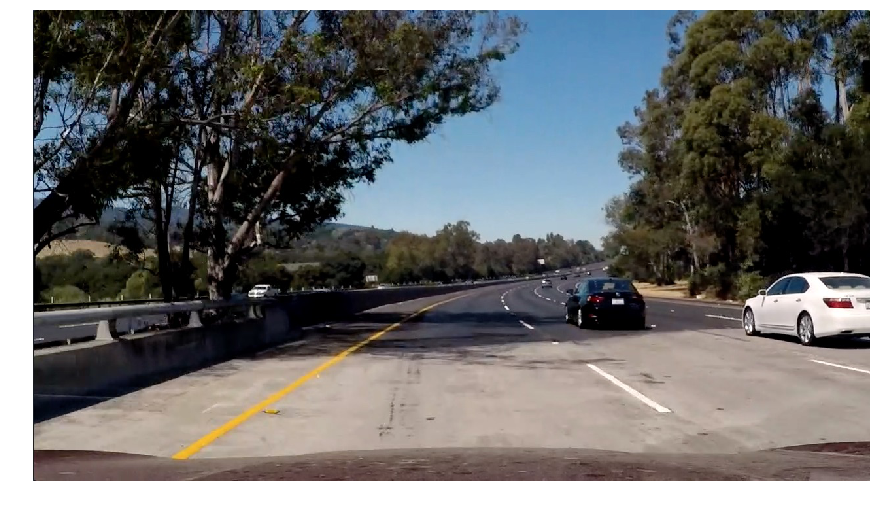

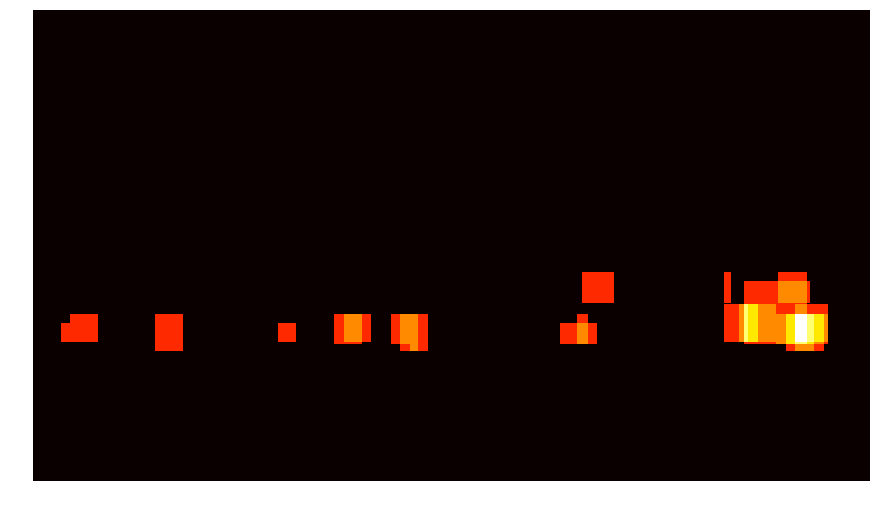

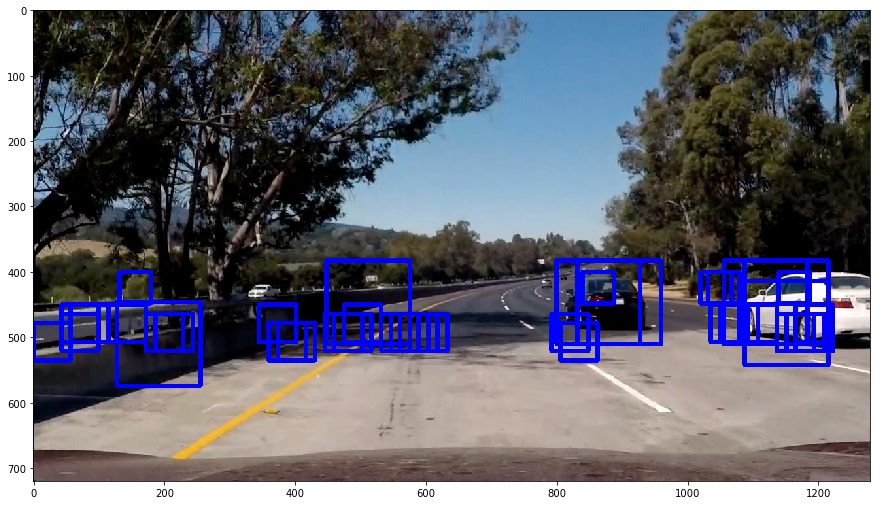

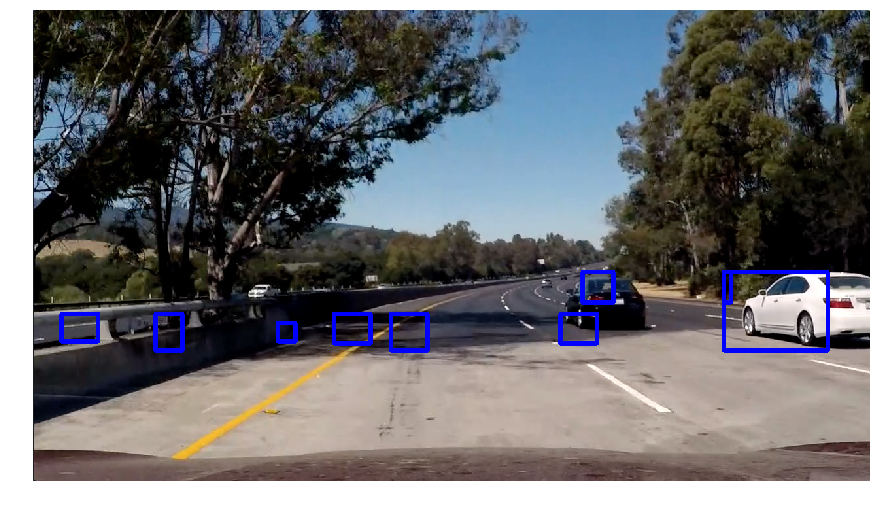

In [200]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
%matplotlib inline

test_image = mpimg.imread('../test_images/test5.jpg')

detector = VehicleDectection(X_scaler, svc, test_image)

window_list, img, heatmap, final_image = detector.detect_vehicles(test_image)


show_image(test_image)
show_image(heatmap, cmap='hot')
show_image(img, axis=True)


show_image(final_image)


